# RNN Tensorflow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# fix_yahoo_finance is used to fetch data 
import fix_yahoo_finance as yf
yf.pdr_override()

In [2]:
# input
symbol = 'AAPL'
start = '2012-01-01'
end = '2018-01-01'

# Read data 
dataset = yf.download(symbol,start,end)

# View Columns
dataset.head()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,58.485714,58.928570,58.428570,58.747143,51.269413,75555200
2012-01-04,58.571430,59.240002,58.468571,59.062859,51.544937,65005500
2012-01-05,59.278572,59.792858,58.952858,59.718571,52.117188,67817400
2012-01-06,59.967144,60.392857,59.888573,60.342857,52.662014,79573200
2012-01-09,60.785713,61.107143,60.192856,60.247143,52.578468,98506100


In [3]:
dataset['Increase_Decrease'] = np.where(dataset['Volume'].shift(-1) > dataset['Volume'],1,0)
dataset['Buy_Sell_on_Open'] = np.where(dataset['Open'].shift(-1) > dataset['Open'],1,0)
dataset['Buy_Sell'] = np.where(dataset['Adj Close'].shift(-1) > dataset['Adj Close'],1,0)
dataset['Returns'] = dataset['Adj Close'].pct_change()
dataset = dataset.dropna()
dataset.head()

,Open,High,Low,Close,Adj Close,Volume,Increase_Decrease,Buy_Sell_on_Open,Buy_Sell,Returns
Date,,,,,,,,,,
2012-01-04,58.571430,59.240002,58.468571,59.062859,51.544937,65005500,1,1,1,0.005374
2012-01-05,59.278572,59.792858,58.952858,59.718571,52.117188,67817400,1,1,1,0.011102
2012-01-06,59.967144,60.392857,59.888573,60.342857,52.662014,79573200,1,1,0,0.010454
2012-01-09,60.785713,61.107143,60.192856,60.247143,52.578468,98506100,0,1,1,-0.001586
2012-01-10,60.844284,60.857143,60.214287,60.462856,52.766739,64549100,0,0,0,0.003581


In [4]:
dataset.shape

(1508, 10)

In [5]:
#Data cleaning
dataset.isna().any()

Open                 False
High                 False
Low                  False
Close                False
Adj Close            False
Volume               False
Increase_Decrease    False
Buy_Sell_on_Open     False
Buy_Sell             False
Returns              False
dtype: bool

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1508 entries, 2012-01-04 to 2017-12-29
Data columns (total 10 columns):
Open                 1508 non-null float64
High                 1508 non-null float64
Low                  1508 non-null float64
Close                1508 non-null float64
Adj Close            1508 non-null float64
Volume               1508 non-null int32
Increase_Decrease    1508 non-null int32
Buy_Sell_on_Open     1508 non-null int32
Buy_Sell             1508 non-null int32
Returns              1508 non-null float64
dtypes: float64(6), int32(4)
memory usage: 106.0 KB


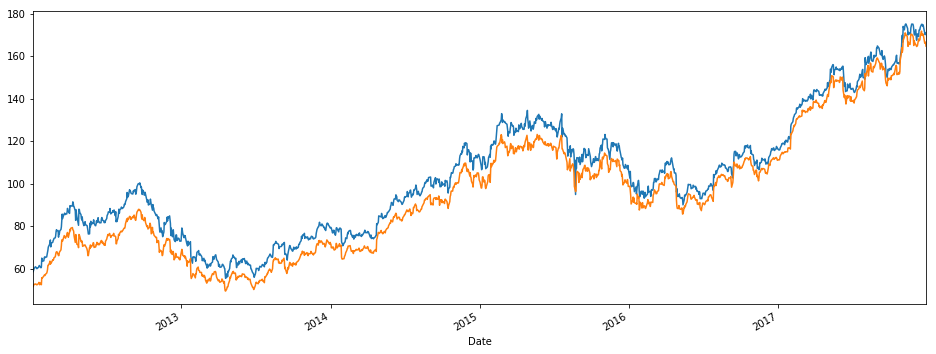

In [7]:
dataset['Open'].plot(figsize=(16, 6))
dataset['Adj Close'].plot(figsize=(16, 6))
plt.show()

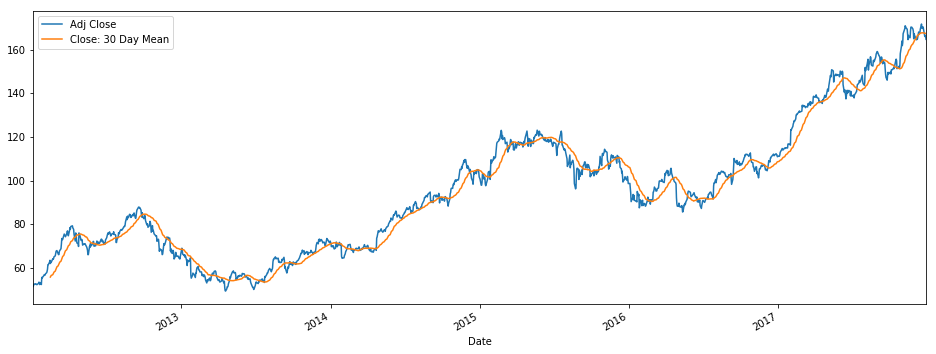

In [8]:
dataset['Close: 30 Day Mean'] = dataset['Adj Close'].rolling(window=30).mean()
dataset[['Adj Close', 'Close: 30 Day Mean']].plot(figsize=(16, 6))
plt.show()

## Training Dataset

In [9]:
train_data = dataset['Adj Close']
train_data = pd.DataFrame(train_data)

In [10]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)

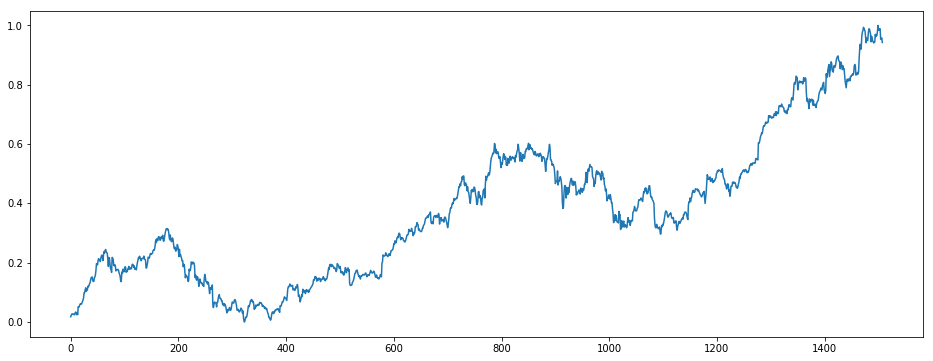

In [11]:
plt.figure(figsize=(16, 6))
plt.plot(train_data_scaled)
plt.show()

In [12]:
# Creating a data structure with 60 timesteps and 1 output
past_days = 60
X_train = []
y_train = []
for i in range(past_days, len(train_data_scaled)):
  X_train.append(train_data_scaled[i-past_days:i, 0])
  y_train.append(train_data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Cast
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

In [13]:
# We predict the price of next day given past 60 days prices
print(X_train.shape)
print(y_train.shape)

(1448, 60, 1)
(1448,)


## Build a Model

In [14]:
import tensorflow as tf
from tensorflow.keras import layers

In [15]:
model = tf.keras.Sequential()

In [16]:
# Adding the first LSTM layer
model.add(layers.LSTM(units=50, input_shape=(past_days, 1)))

# Adding the output layer
model.add(layers.Dense(units=1))

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Compiling the RNN
model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mean_squared_error')

In [20]:
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 0.0305
Epoch 2/10
1448/1448 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 3/10
1448/1448 [==============================] - 2s 1ms/step - loss: 6.2046e-04
Epoch 4/10
1448/1448 [==============================] - 2s 1ms/step - loss: 5.8294e-04
Epoch 5/10
1448/1448 [==============================] - 2s 1ms/step - loss: 5.6334e-04
Epoch 6/10
1448/1448 [==============================] - 2s 1ms/step - loss: 5.6394e-04
Epoch 7/10
1448/1448 [==============================] - 1s 1ms/step - loss: 5.3401e-04

## Test Dataset

In [21]:
test_dataset = yf.download(symbol,start='2018-01-01', end='2019-01-01')

[*********************100%***********************]  1 of 1 downloaded


In [22]:
test_dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,170.160004,172.300003,169.259995,172.259995,167.701889,25555900
2018-01-03,172.529999,174.550003,171.960007,172.229996,167.672668,29517900
2018-01-04,172.539993,173.470001,172.080002,173.029999,168.451508,22434600
2018-01-05,173.440002,175.369995,173.050003,175.000000,170.369385,23660000
2018-01-08,174.350006,175.610001,173.929993,174.350006,169.736588,20567800


In [23]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2018-01-02 to 2018-12-31
Data columns (total 6 columns):
Open         251 non-null float64
High         251 non-null float64
Low          251 non-null float64
Close        251 non-null float64
Adj Close    251 non-null float64
Volume       251 non-null int32
dtypes: float64(5), int32(1)
memory usage: 12.7 KB


In [24]:
test_data = test_dataset['Adj Close']
test_data = pd.DataFrame(test_data)

In [25]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2018-01-02 to 2018-12-31
Data columns (total 1 columns):
Adj Close    251 non-null float64
dtypes: float64(1)
memory usage: 3.9 KB


In [26]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
test_set_scaled = sc.fit_transform(test_data)

In [27]:
test_set_scaled = pd.DataFrame(test_set_scaled)
test_set_scaled.head()

,0
0,0.271009
1,0.270658
2,0.279993
3,0.302980
4,0.295396


In [35]:
# Getting the predicted stock price of 2018
dataset_total = pd.concat((dataset['Adj Close'], test_dataset['Adj Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_dataset) - past_days:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []

prediction_days = test_dataset.shape[0]
for i in range(past_days, past_days + prediction_days):
  X_test.append(inputs[i-past_days:i, 0])
  y_test.append(inputs[i, 0])
  
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Cast
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [36]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

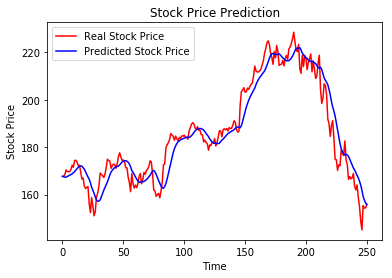

In [37]:
# Visualising the results
real_stock_price = test_dataset['Adj Close'].values
plt.plot(real_stock_price, color='red', label='Real Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [38]:
result = model.evaluate(X_test, y_test)

251/251 [==============================] - 0s 617us/step


In [39]:
print("Mean Squared Error: {0:.2%}".format(result))

Mean Squared Error: 0.55%
